## SCANPY and scVELO

In this document I will repeat the analysis of the single cell sequencing data of the LepR+ sorted cells. Since ScanPy used a different approach on some things, finding the same results would validate the Seurat findings. Multiple models using different methods which produce the same y, strengthen our believe in y.

In [1]:
# Libraries
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import seaborn

In [10]:
# Set some settings for Scanpy
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80) # This is the resolution of figures
source = "/home/jeppe/internships/tdtomato_lepr_jeppeseverens/ScanPy_ScVelo" # Add your working directory
results_file = '/result.h5ad'  # the file that will store the analysis results

scanpy==1.6.0 anndata==0.7.5 umap==0.4.6 numpy==1.19.2 scipy==1.5.2 pandas==1.1.3 scikit-learn==0.23.2 statsmodels==0.12.0 python-igraph==0.7.1 leidenalg==0.8.2


Now I have done this analysis already, and you can import the results and add to this on your own by running the cell below. If you want to rerun everything yourself skip this cell below.

In [7]:
# Import processed file, skip if you want to do everything on your own
adata = sc.read(source + results_file)

We are running both the Scanpy pipeline and the ScVelo pipeline. ScVelo works with the spliced and unspliced reads, and determines the "velocity" or the "direction" a sequences cell is moving to by taking the spliced reads as "now" and the unspliced as the "future". (in very simple terms) For more info see Bergen et al. (Nature Biotech, 2020) and https://scvelo.readthedocs.io/ .

In [8]:
# You need the whole dataset, the spliced and unspliced reads from starmap
# We use .T to transpose because Scanpy uses columns = genes and rows = cells.
dataset = sc.read(source + '/merged_starmap_Nef_cellsrenamed_total.coutt.tsv', cache=True).T
spliced = sc.read(source + '/merged_namecor_starmap_Nef_plate_1_spliced.coutt.tsv', cache=True).T
unspliced = sc.read(source + '/merged_namecor_starmap_Nef_plate_1_unspliced.coutt.tsv', cache=True).T

... writing an h5ad cache file to speedup reading next time
... writing an h5ad cache file to speedup reading next time
... writing an h5ad cache file to speedup reading next time


In [3]:
# Lets see if rows (obs) are now cells
dataset.obs_names

Index(['tom_P1_fed_1', 'tom_P1_fed_2', 'tom_P1_fed_3', 'tom_P1_fed_4',
       'tom_P1_fed_5', 'tom_P1_fed_6', 'tom_P1_fed_7', 'tom_P1_fed_8',
       'tom_P1_fed_9', 'tom_P1_fed_10',
       ...
       'emp_P5_fed_375', 'emp_P5_fed_376', 'emp_P5_fed_377', 'emp_P5_fed_378',
       'emp_P5_fed_379', 'emp_P5_fed_380', 'emp_P5_fed_381', 'emp_P5_fed_382',
       'emp_P5_fed_383', 'emp_P5_fed_384'],
      dtype='object', name='index', length=1920)

In [4]:
# We then create one big Scanpy object with the total reads as the standard expression matrix
# And the spliced and unspliced information as layers
adata = dataset
adata.layers['spliced'] = spliced.X
adata.layers['unspliced'] = unspliced.X

In [9]:
# Show proportions of spliced/unspliced abundances
scv.utils.show_proportions(adata)
adata

Abundance of ['spliced', 'unspliced']: [0.66 0.34]


AnnData object with n_obs × n_vars = 838 × 5983
    obs: 'ERCC_genes', 'n_counts_withERCCmito', 'n_genes', 'n_counts_with_mito', 'percent_mito', 'n_counts', 'type', 'plate', 'condition', 'louvain', 'velocity_self_transition', 'velocity_clusters'
    var: 'fullname', 'ENS_names', 'geneid', 'feature', 'chr', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'velocity_gamma', 'velocity_r2', 'velocity_genes', 'velocity_score'
    uns: 'condition_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups', 'rank_velocity_genes', 'velocity_graph', 'velocity_graph_neg', 'velocity_settings'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'spliced', 'unspliced', 'variance_velocity', 'velocity'
    obsp: 'distances', 'connectivities'

From here we will run the standard ScanPy pipeline

We will start with the ERCC spike-ins, we can add the total sum of the ERCC counts per cell as meta data
We will also modify the gene names so that the information in these gene names is split and added as meta data
Lastly we will remove the ERCC genes, because we did not use them in Seurat either

In [11]:
# Find ERCC genes
ERCC_genes = adata.var_names.str.startswith('ERCC')
# Sum them
adata.obs['ERCC_genes'] = np.sum(
    adata[:, ERCC_genes].X, axis=1) / np.sum(adata.X, axis=1) #.A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts_withERCCmito'] = adata.X.sum(axis=1) #.A1

In [12]:
# Here, we will split the gene names and add as an attribute for 
# each gene to a new category in the AnnData file
adata.var['fullname'] = adata.var_names
adata.var['ENS_names'] = adata.var_names.str.split('_').str[0]
adata.var['geneid'] = adata.var_names.str.split('_').str[1]
adata.var['feature'] = adata.var_names.str.split('__').str[1]
adata.var['chr'] = adata.var_names.str.split('__').str[1]

# Calculate number of genes
sc.pp.filter_cells(adata, min_genes=0)

In [13]:
# List the ERCC genes
non_ERCC_genes_list = [name for name in adata.var_names if not name.startswith('ERCC')]
# Remove ERCC genes by taking all the non ERCC genes out of adata
adata = adata[:, non_ERCC_genes_list] 

Trying to set attribute `.obs` of view, copying.


Now we need to filter the cells also. First we will remove all cels with expression of less then 10 genes.
Then we will move on to the mitochondrial genes.

In [14]:
sc.pp.filter_cells(adata, min_genes=10)

In [16]:
# Number of counts with mito genes, added as meta data
adata.obs['n_counts_with_mito'] = adata.X.sum(axis=1)

# Grep the mito genes
mito_genes = adata.var_names.str.endswith('MT')
# For each cell compute fraction of counts in mito genes vs. all genes 
# the `.A1` is only necessary if X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1) #.A1

# Now remove the mito genes so that they dont effect downstream analysis
non_mito_genes_list = [name for name in adata.var_names if not name.endswith('MT')]
adata = adata[:, non_mito_genes_list] 

# Add number of genes as metadata
adata.obs['n_counts'] = adata.X.sum(axis=1) #.A1

Trying to set attribute `.obs` of view, copying.


In [12]:
# More metdata
adata.obs['type'] = adata.obs_names.str.split('_').str[0]
adata.obs['plate'] = adata.obs_names.str.split('_').str[1]
adata.obs['condition'] = adata.obs_names.str.split('_').str[2]

In [13]:
# Now finally we do the last modification to the gene names and set the variable names to the "gene names"
adata.var_names = adata.var_names.str.split('_').str[1]
adata.var_names_make_unique  # this is unnecessary if using 'gene_ids'

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


<bound method AnnData.var_names_make_unique of AnnData object with n_obs × n_vars = 1870 × 36019 
    obs: 'ERCC_genes', 'n_counts_withERCCmito', 'n_genes', 'n_counts_with_mito', 'percent_mito', 'n_counts', 'type', 'plate', 'condition'
    var: 'fullname', 'ENS_names', 'geneid', 'feature', 'chr'
    layers: 'spliced', 'unspliced'>

In [16]:
# Lastly we only keep the cells which were facs sorted for tdtomato
tom_cell_list = [name for name in adata.obs_names if name.startswith('tom')]
adata = adata[tom_cell_list]

Lots of data processing, but now we can finally do the real filtering. 
We use the same filter settings as used in Seurat.
Cells need to express a minimum of 2000 genes and have less then 15% mito rna.

In [17]:
# Filter
# min.genes
sc.pp.filter_cells(adata, min_genes=2000)
# Mito %
adata = adata[adata.obs['percent_mito'] < 0.15, :]

filtered out 386 cells that haveless than 2000 genes expressed


Trying to set attribute `.obs` of view, making a copy.


And we can do the normalisation, take the log.
Find higly variable genes and regress out percent_mito

In [18]:
# Normalise + take log 
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
# Store raw data, before higly variable gene filtering
adata.raw = adata
# Find variable genes and only keep these
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var['highly_variable']]
# Regress out percent_mito 
sc.pp.regress_out(adata, ['n_counts','percent_mito'])

normalizing by total count per cell


Trying to set attribute `.obs` of view, making a copy.


    finished (0:00:09): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:15)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['n_counts', 'percent_mito']


Trying to set attribute `.obs` of view, making a copy.
... storing 'type' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'plate' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'condition' as categorical
Trying to set attribute `.var` of view, making a copy.
... storing 'geneid' as categorical
Trying to set attribute `.var` of view, making a copy.
... storing 'feature' as categorical
Trying to set attribute `.var` of view, making a copy.
... storing 'chr' as categorical


    finished (0:00:40)


In [19]:
# Finally we scale and center and perform PCA
sc.pp.scale(adata, max_value=10)

In [20]:
# PCA
sc.tl.pca(adata, svd_solver='arpack')
adata.write(results_file)

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:03)


... storing 'geneid' as categorical
... storing 'feature' as categorical
... storing 'chr' as categorical


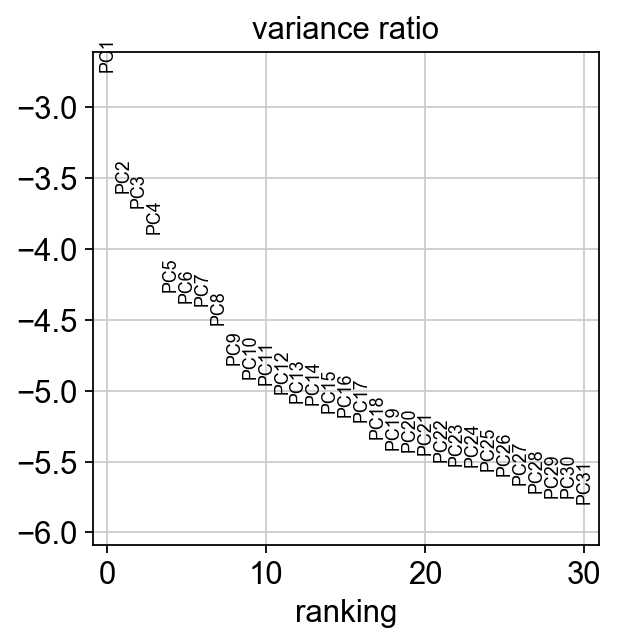

In [58]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=30)

In [10]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=30)
# In seurat I used Jackstraw to select significant pcs, here I just took the first 30 pcs
# changed n_neighbors to 20 because Seurat considers k=20 for FindNeighbours, I dont know if this is correct!


# PS. interesting that a german lab uses Neighbor and a lab in NY uses Neighbours 

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:03)


In [11]:
# Of course we need UMAP to visualise
sc.tl.umap(adata)
# We set the figure settings to scvelo, which just improves the look of the images
scv.settings.set_figure_params('scvelo')

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


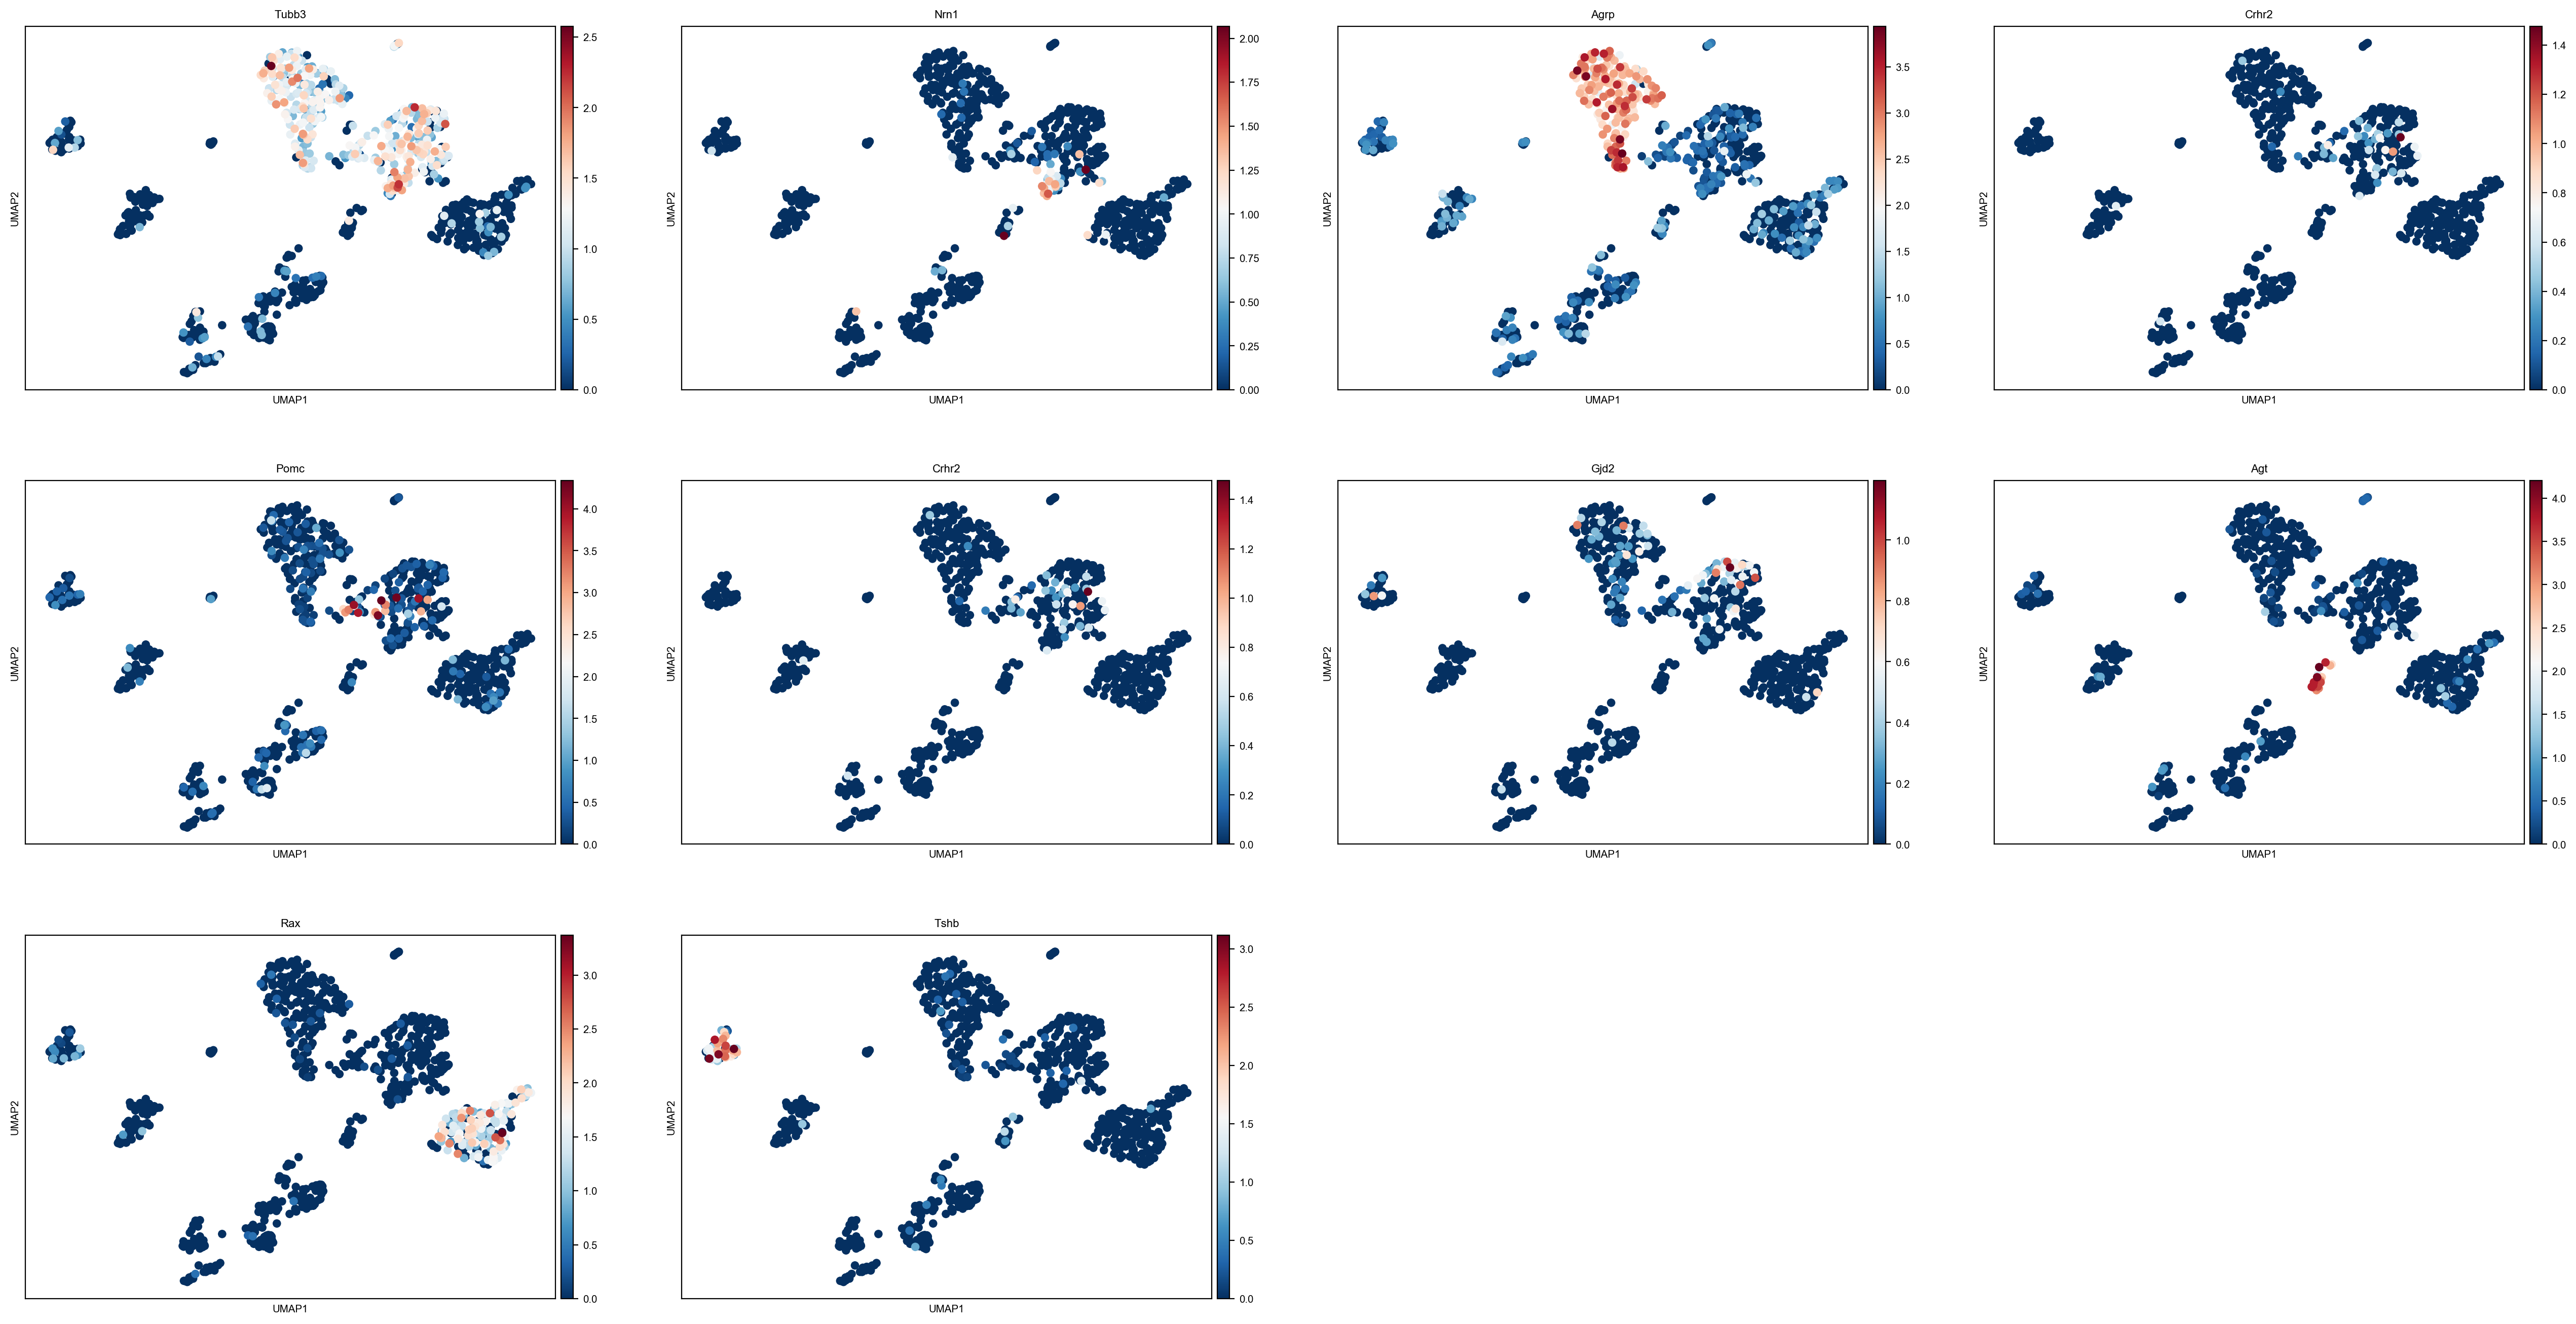

In [12]:
# Now we can see where our cell markers are expressed in dotplots
sc.pl.umap(adata, color=['Tubb3','Nrn1','Agrp','Crhr2',
                         'Pomc','Crhr2','Gjd2','Agt',
                         'Rax', "Tshb"])

In [16]:
# Time to cluster, I used resolution = 4 because this gave the same amount of clusters as per seurat
sc.tl.louvain(adata, resolution = 4) 

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 24 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


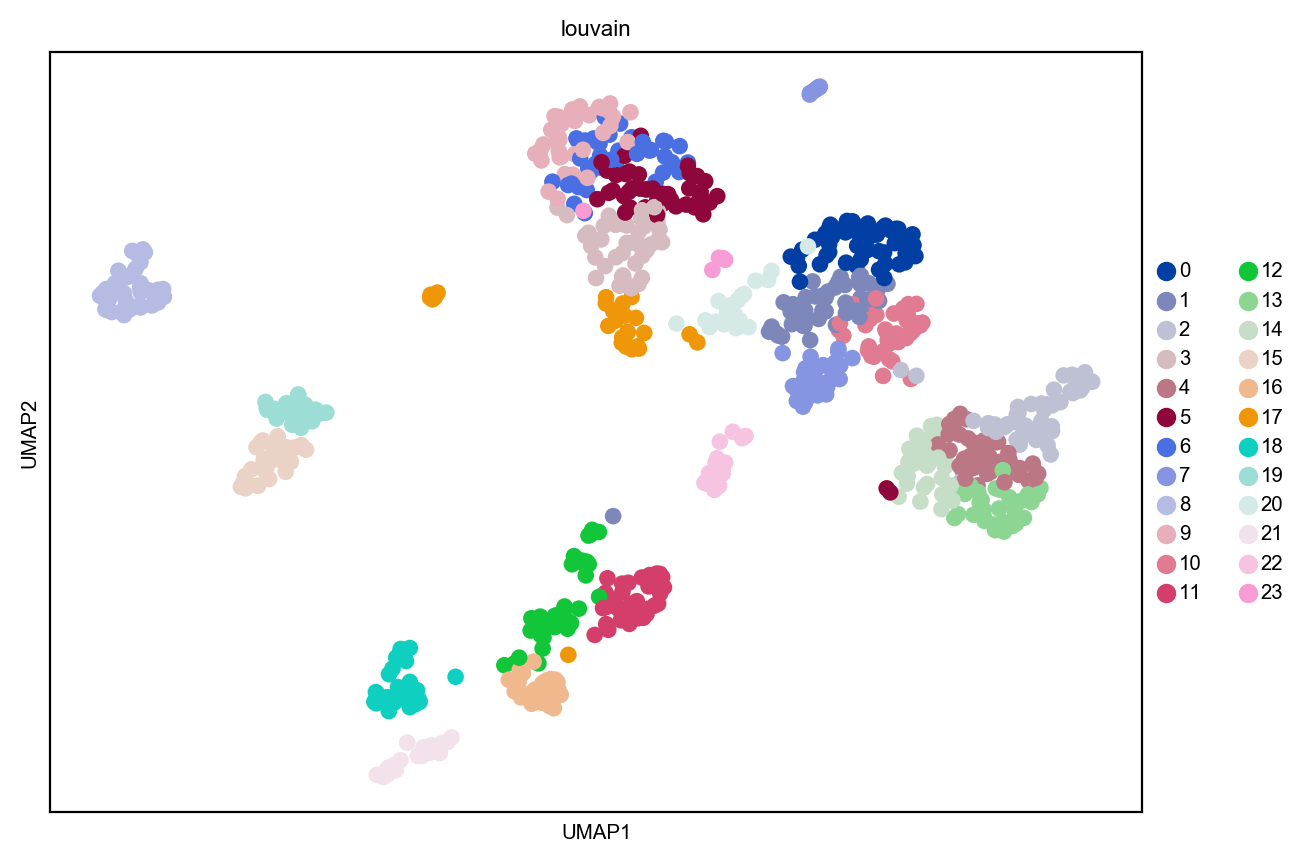

In [17]:
# Show the clusters
sc.pl.umap(adata, color=['louvain'])

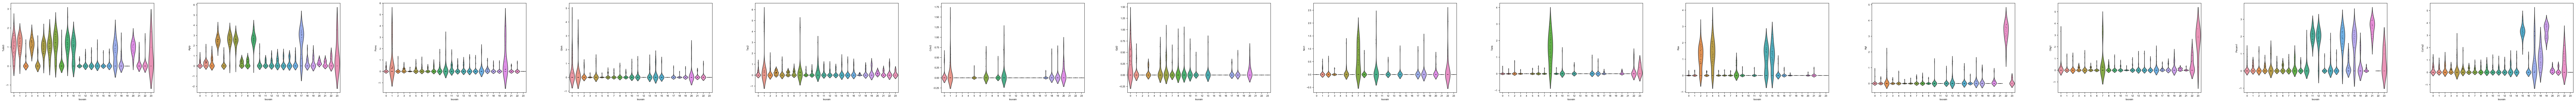

In [15]:
# Check out if we have the same clusters
sc.pl.violin(adata, 
             ['Tubb3', 
              'Agrp', 
              'Pomc', 
              'Ghrh', 
              "Tac2", 
              "Crhr2", 
              "Gjd2", 
              "Nrn1", 
              "Tshb", 
              "Rax", 
              "Agt", 
              "Olig1", 
              "Pecam1", 
              "Col1a2"],
             raw = False, groupby='louvain')

# Looks mostly the same? 
# VLMCs is only one cluster here and 2 in seurat
# Gal/Ghrh dont cluster on their own
# Crhr2 is not a good marker in scanpy
# 2 pomc clusters? Could just be resolution pushing

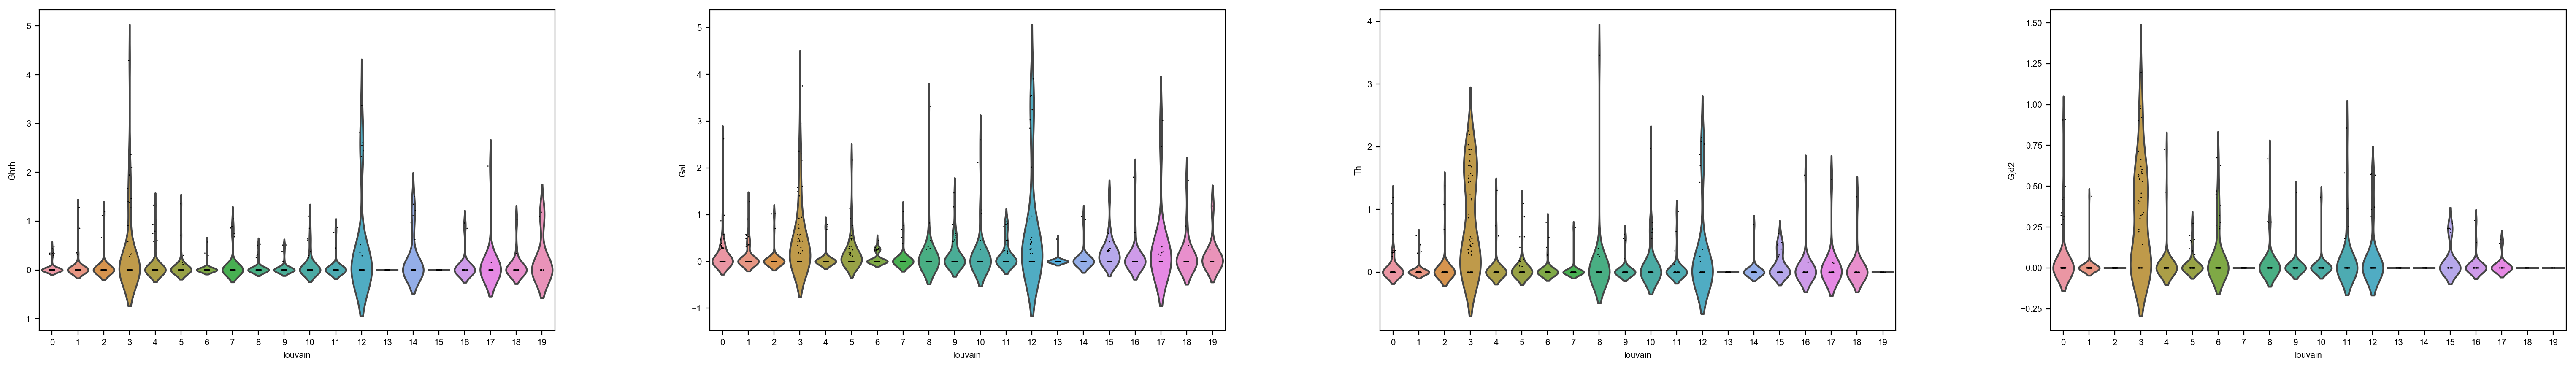

In [132]:
sc.pl.violin(adata, ['Ghrh', "Gal", "Th", "Gjd2"], raw = False, groupby='louvain') 

# Ghrh/Gal together are their own cluster in seurat, here they spread out over gjd2 and crhr2 cluster? 
# Does not change if I push resolution

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:07)


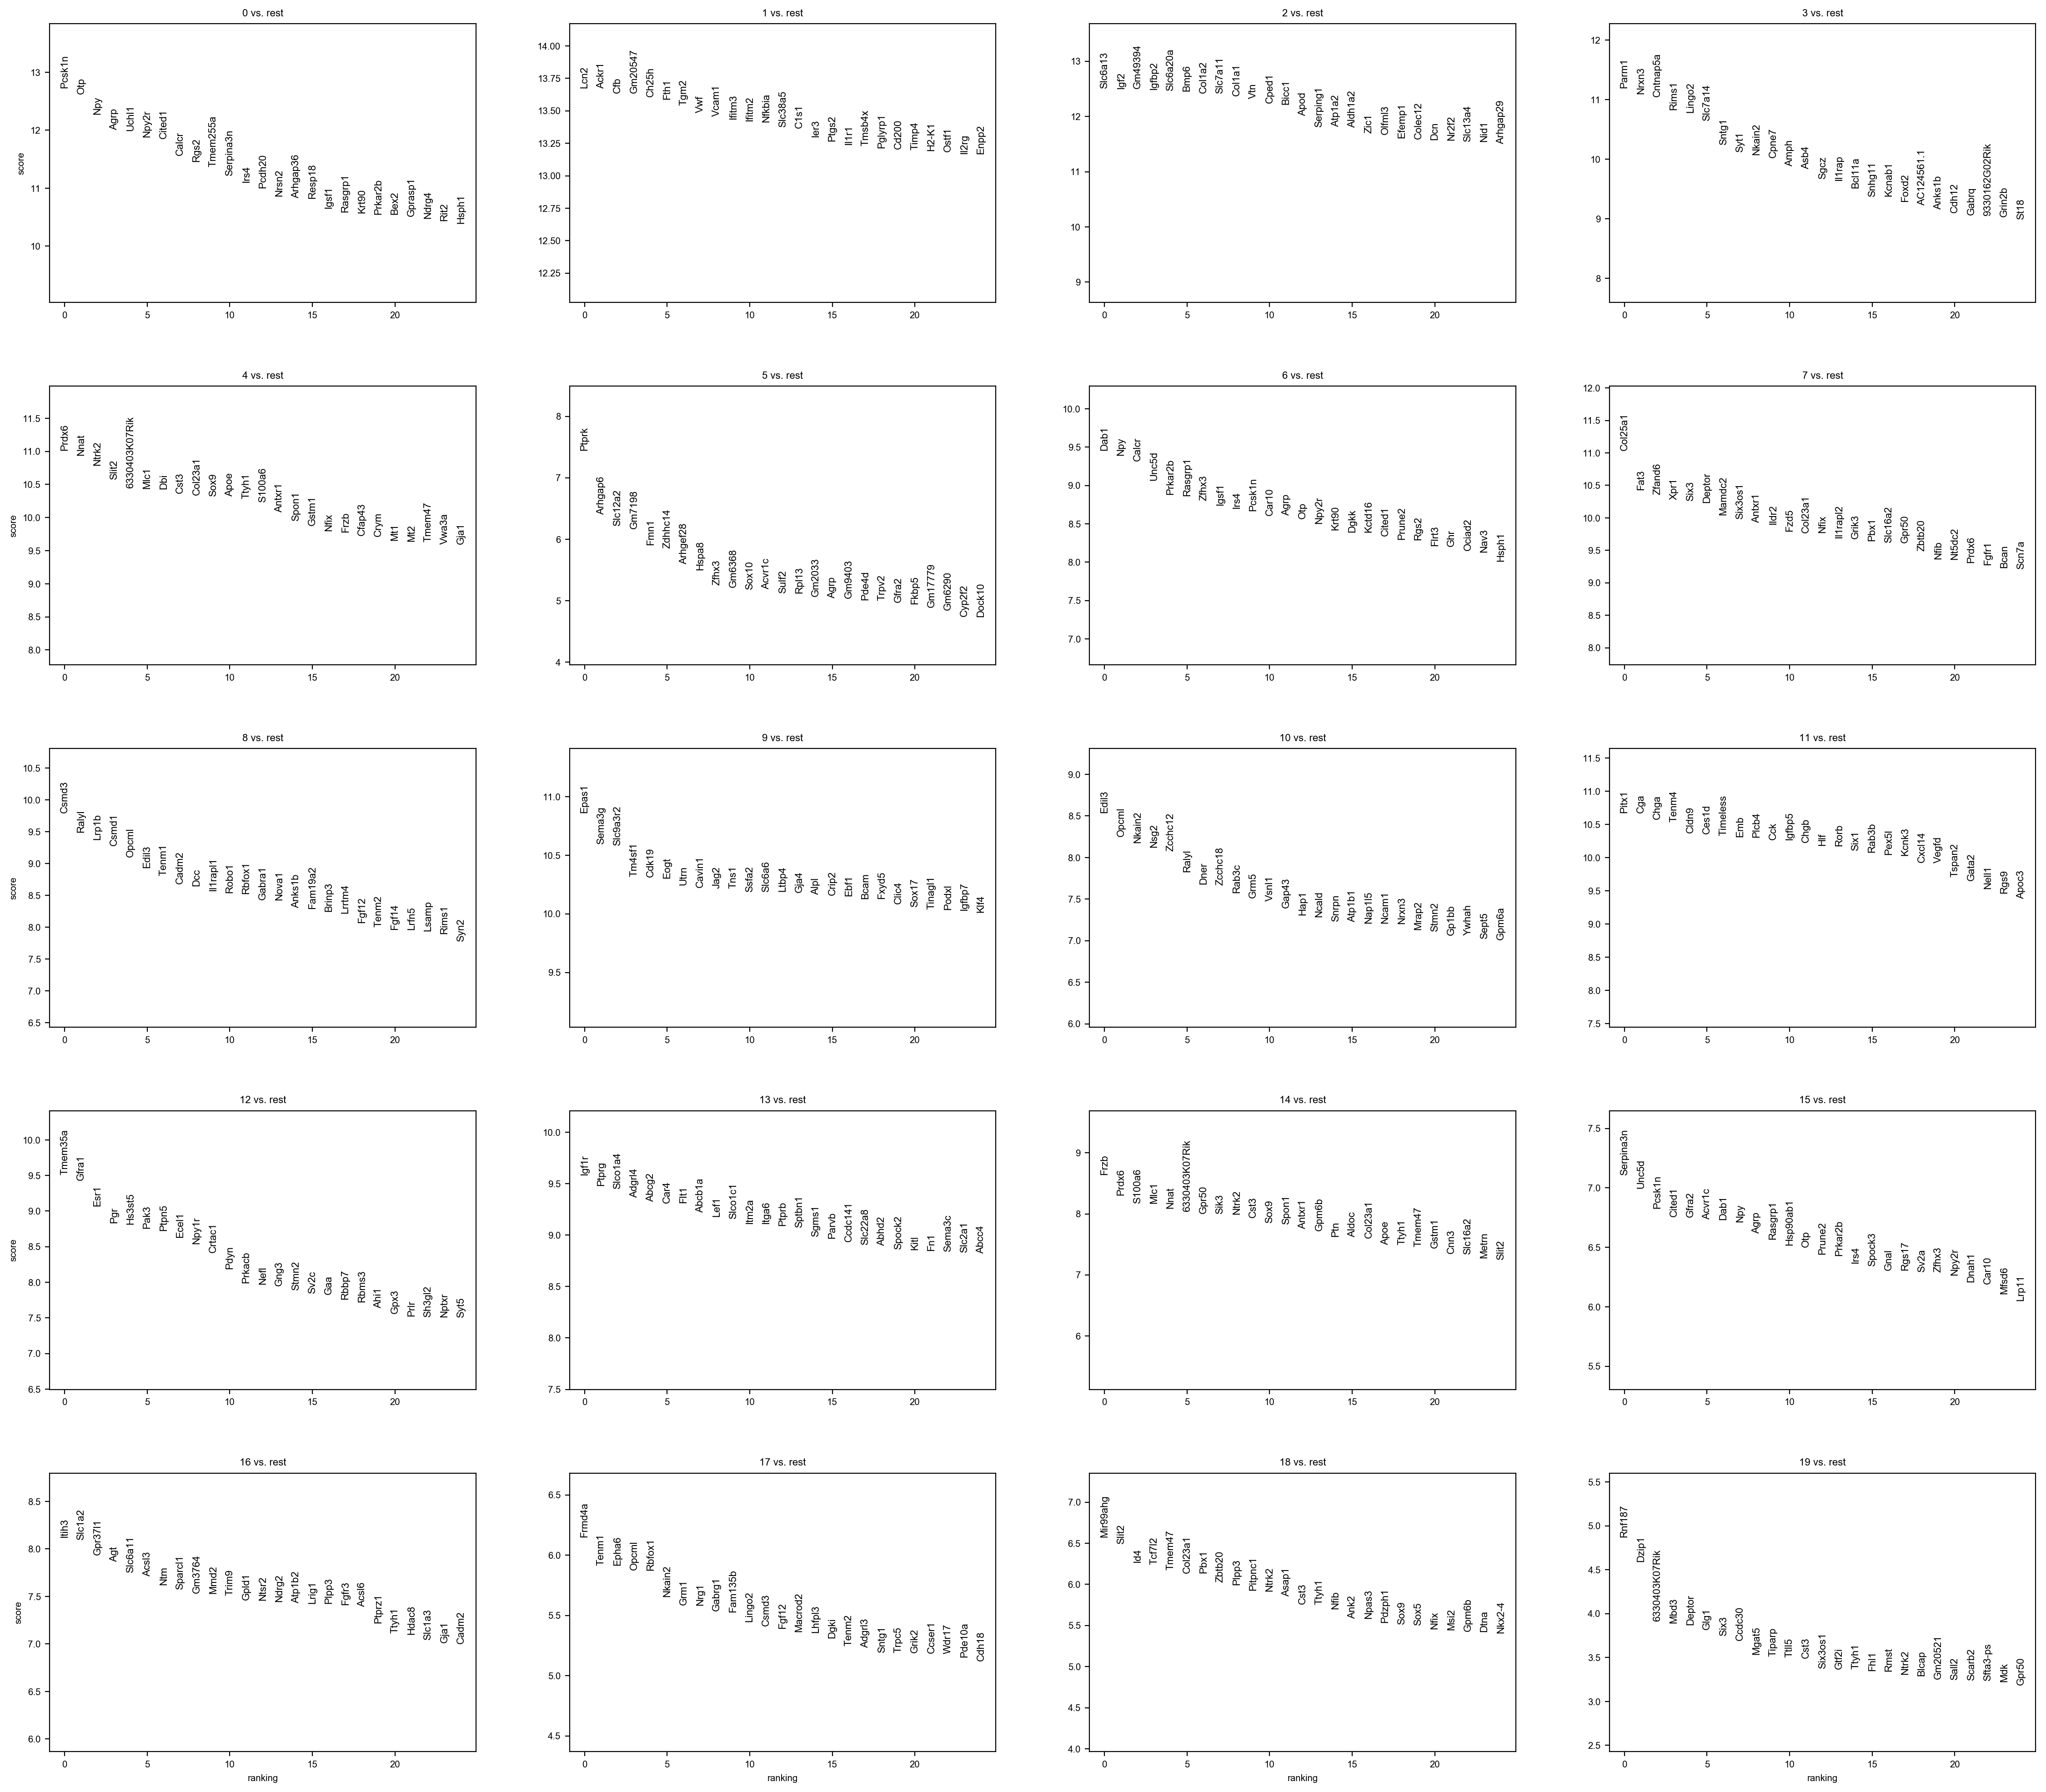

In [137]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [138]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10) # top 10 marker genes for each cluster

0        1         2         3              4         5        6  \
0    Pcsk1n     Lcn2   Slc6a13     Parm1          Prdx6     Ptprk     Dab1   
1       Otp    Ackr1      Igf2     Nrxn3           Nnat   Arhgap6      Npy   
2       Npy      Cfb   Gm49394  Cntnap5a          Ntrk2   Slc12a2    Calcr   
3      Agrp  Gm20547    Igfbp2     Rims1          Slit2    Gm7198    Unc5d   
4     Uchl1    Ch25h  Slc6a20a    Lingo2  6330403K07Rik      Fmn1  Prkar2b   
5     Npy2r     Fth1      Bmp6   Slc7a14           Mlc1   Zdhhc14  Rasgrp1   
6    Cited1     Tgm2    Col1a2     Sntg1            Dbi  Arhgef28    Zfhx3   
7     Calcr      Vwf   Slc7a11      Syt1           Cst3     Hspa8    Igsf1   
8      Rgs2    Vcam1    Col1a1    Nkain2        Col23a1     Zfhx3     Irs4   
9  Tmem255a   Ifitm3       Vtn     Cpne7           Sox9    Gm6368   Pcsk1n   

         7         8         9       10        11       12       13  \
0  Col25a1     Csmd3     Epas1    Edil3     Pitx1  Tmem35a    Igf1r   
1     Fat3     Ralyl    Sema3g    Opcml       Cga    Gfra1    Ptprg   
2   Zfand6     Lrp1b  Slc9a3r2   Nkain2      Chga     Esr1  Slco1a4   
3     Xpr1     Csmd1    Tm4sf1     Nsg2     Tenm4      Pgr   Adgrl4   
4     Six3     Opcml     Cdk19  Zcchc12     Cldn9   Hs3st5    Abcg2   
5   Deptor     Edil3      Eogt    Ralyl     Ces1d     Pak3     Car4   
6   Mamdc2     Tenm1      Utrn     Dner  Timeless    Ptpn5     Flt1   
7  Six3os1     Cadm2    Cavin1  Zcchc18       Emb    Ecel1   Abcb1a   
8   Antxr1       Dcc      Jag2    Rab3c     Plcb4    Npy1r     Lef1   
9    Ildr2  Il1rapl1      Tns1     Grm5       Cck   Crtac1  Slco1c1   

              14         15       16       17        18             19  
0           Frzb  Serpina3n    Itih3   Frmd4a  Mir99ahg         Rnf187  
1          Prdx6      Unc5d   Slc1a2    Tenm1     Slit2          Dzip1  
2         S100a6     Pcsk1n  Gpr37l1    Epha6       Id4  6330403K07Rik  
3           Mlc1     Cited1      Agt    Opcml    Tcf7l2           Mbd3  
4           Nnat      Gfra2  Slc6a11   Rbfox1    Tmem47         Deptor  
5  6330403K07Rik     Acvr1c    Acsl3   Nkain2   Col23a1           Glg1  
6          Gpr50       Dab1      Ntm     Grm1      Pbx1           Six3  
7           Sik3        Npy  Sparcl1     Nrg1    Zbtb20         Ccdc30  
8          Ntrk2       Agrp   Gm3764   Gabrg1     Plpp3          Mgat5  
9           Cst3    Rasgrp1     Mmd2  Fam135b   Pitpnc1         Tiparp

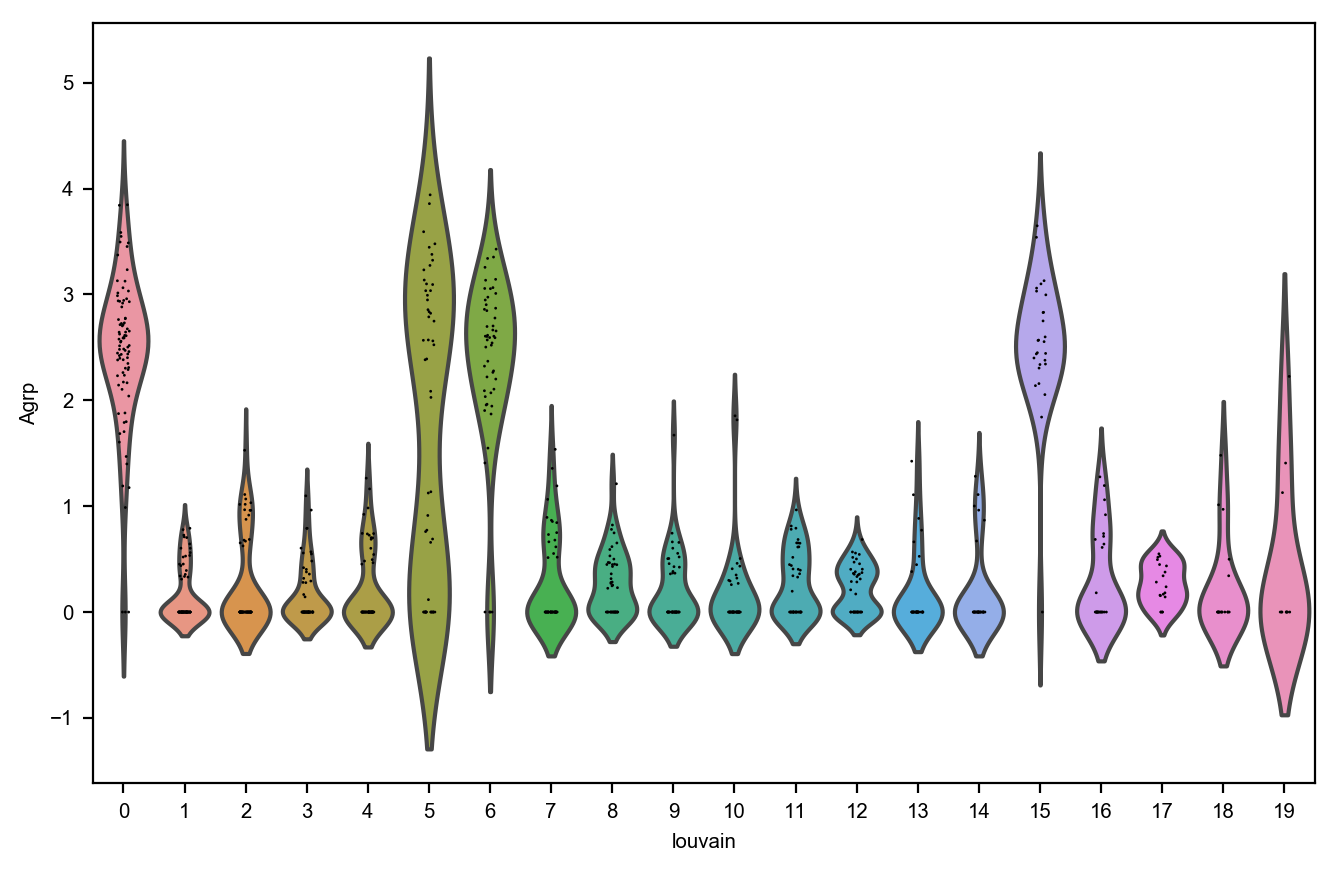

In [133]:
sc.pl.violin(adata, ['Agrp'], raw = False, groupby='louvain')  
# 0, 5, 6, 15 are agrp

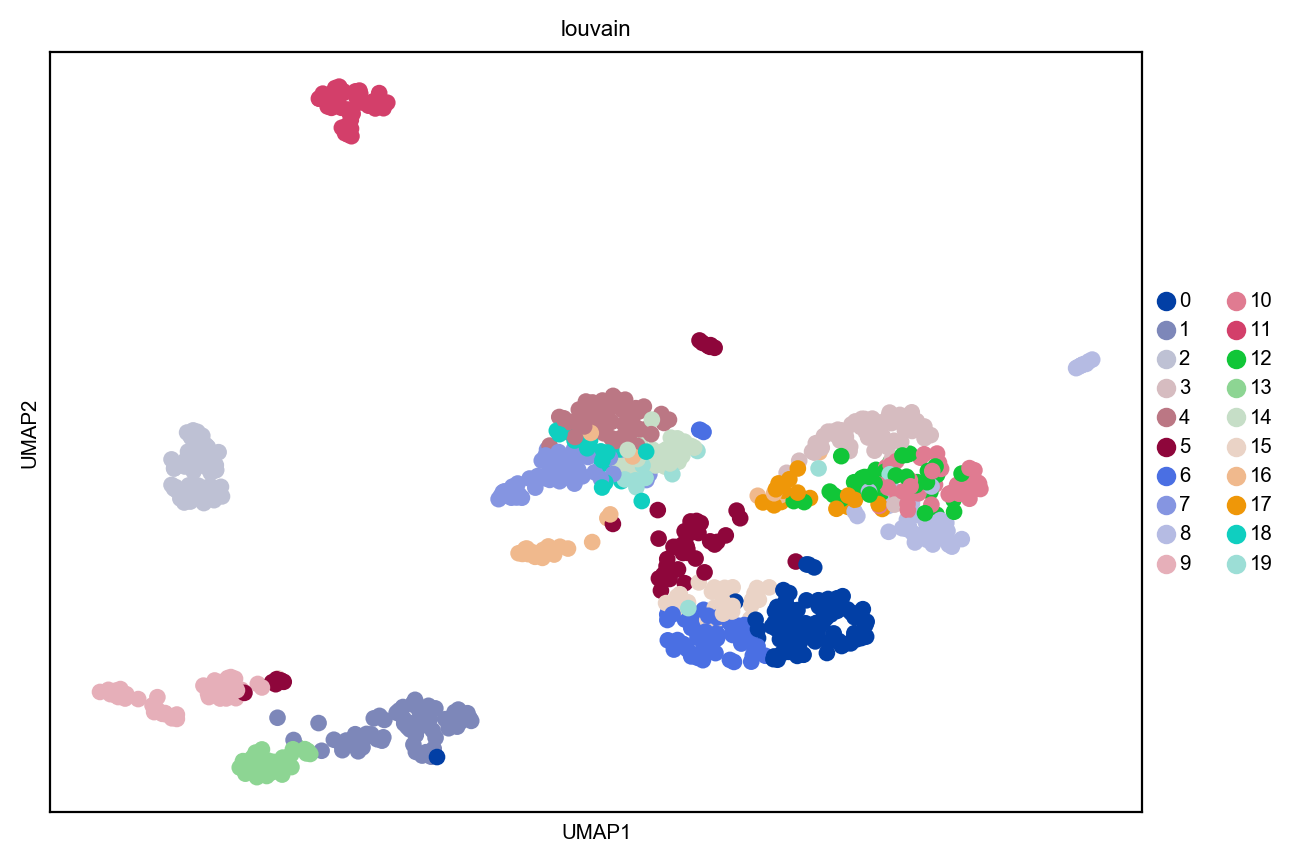

In [98]:
sc.pl.umap(adata, color=['louvain']) 
# 0, 5, 6, 15 are agrp

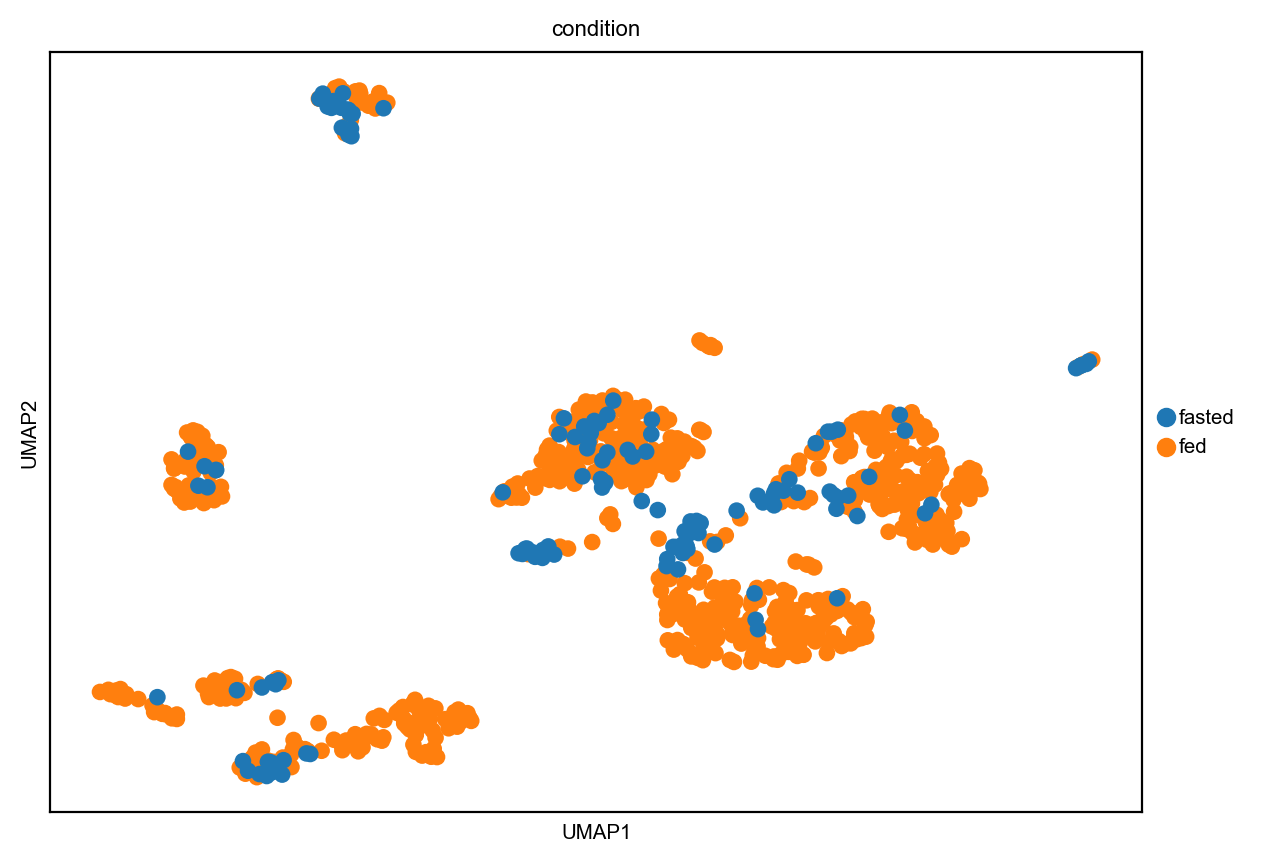

In [134]:
sc.pl.umap(adata, color=['condition']) 
# Fasted agrp still mostly cluster to their own cluster -> cluster 5

## scVELO 

Now we can run scVELO. This is prety easy when we have the fully processed file from ScanPy. 
We only need the function below. I did not further investigate this so this is for another time/person.

In [100]:
scv.tl.velocity(adata)

computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [103]:
# And to prepare graphs we run this
scv.tl.velocity_graph(adata)

computing velocity graph
    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


## Plot results

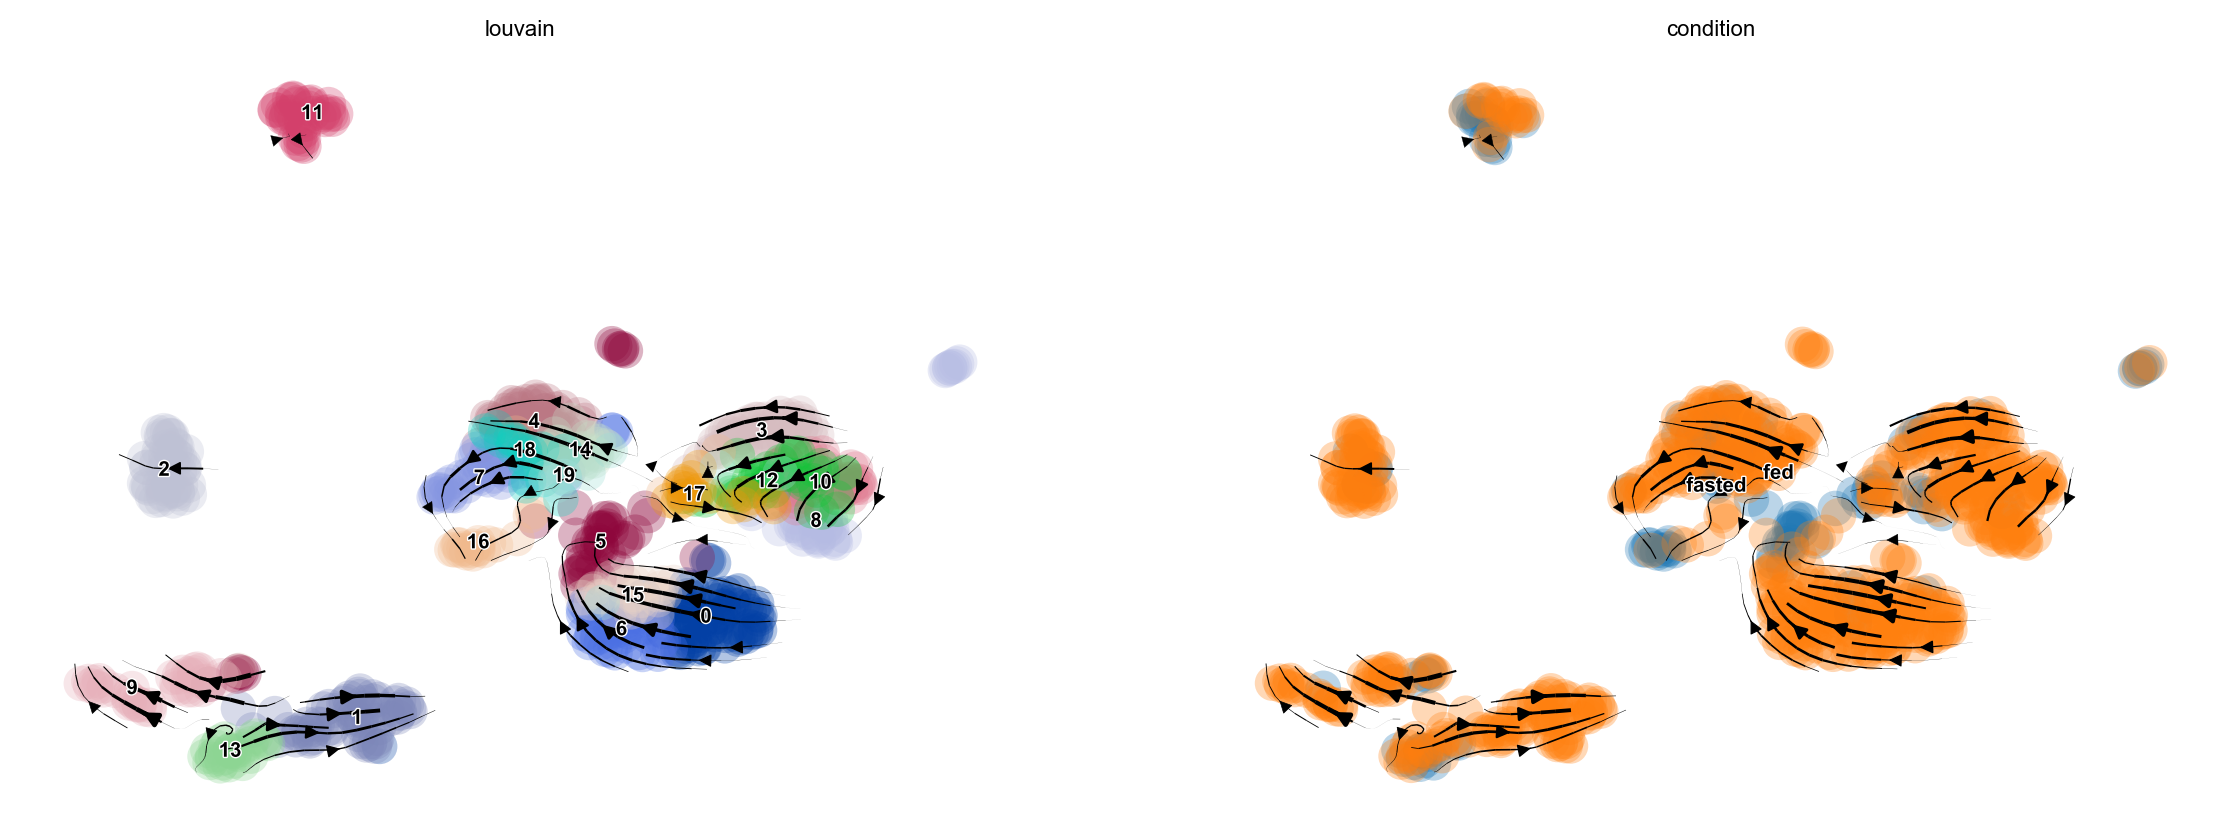

In [109]:
scv.pl.velocity_embedding_stream(adata, basis='umap',color=['louvain', 'condition'])

#I have no idea what this all means


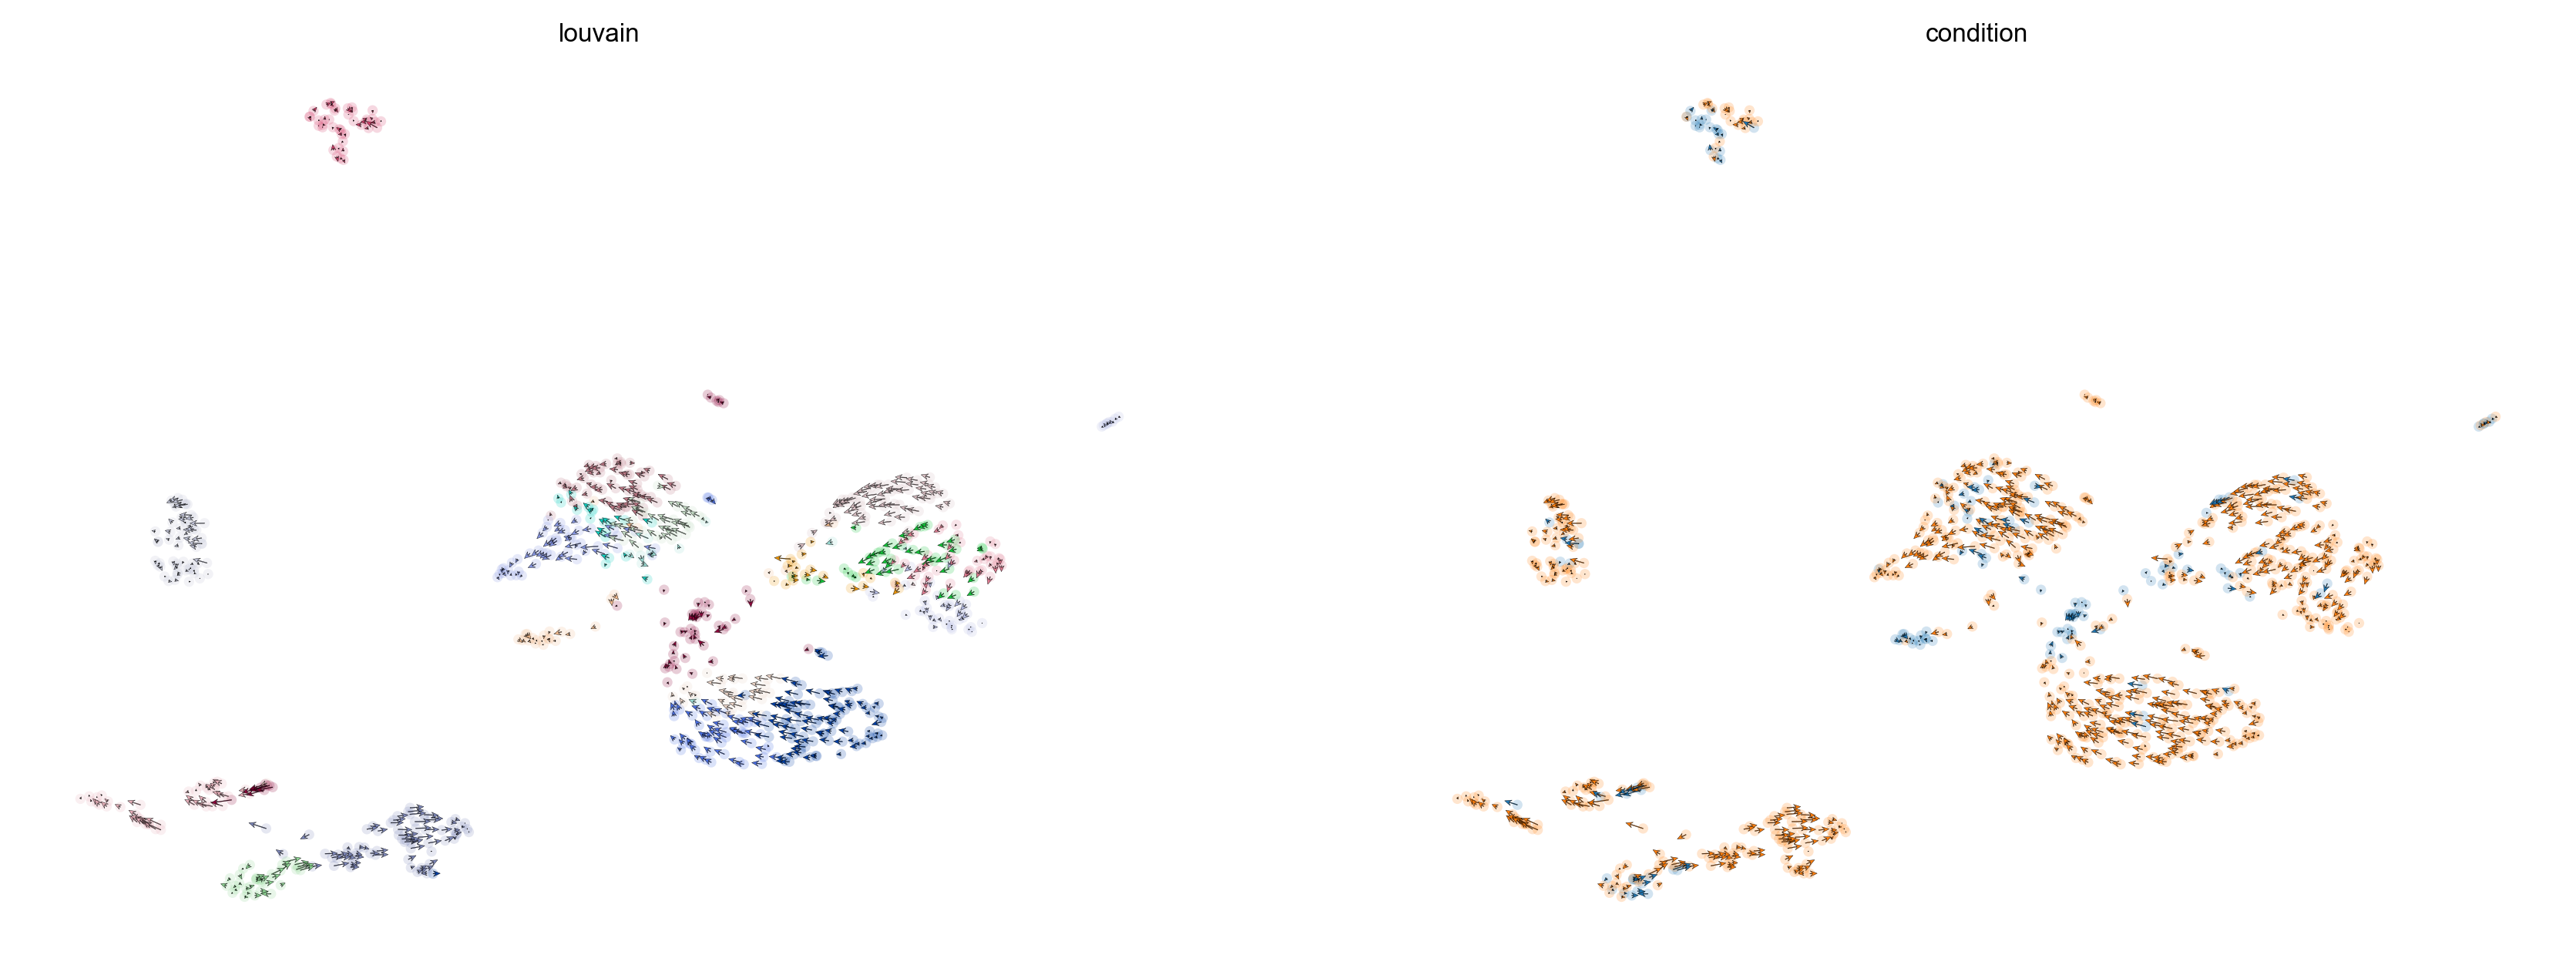

In [110]:
scv.pl.velocity_embedding(adata, basis='umap', dpi=150,color=['louvain', 'condition'])

## Check velocity for genes

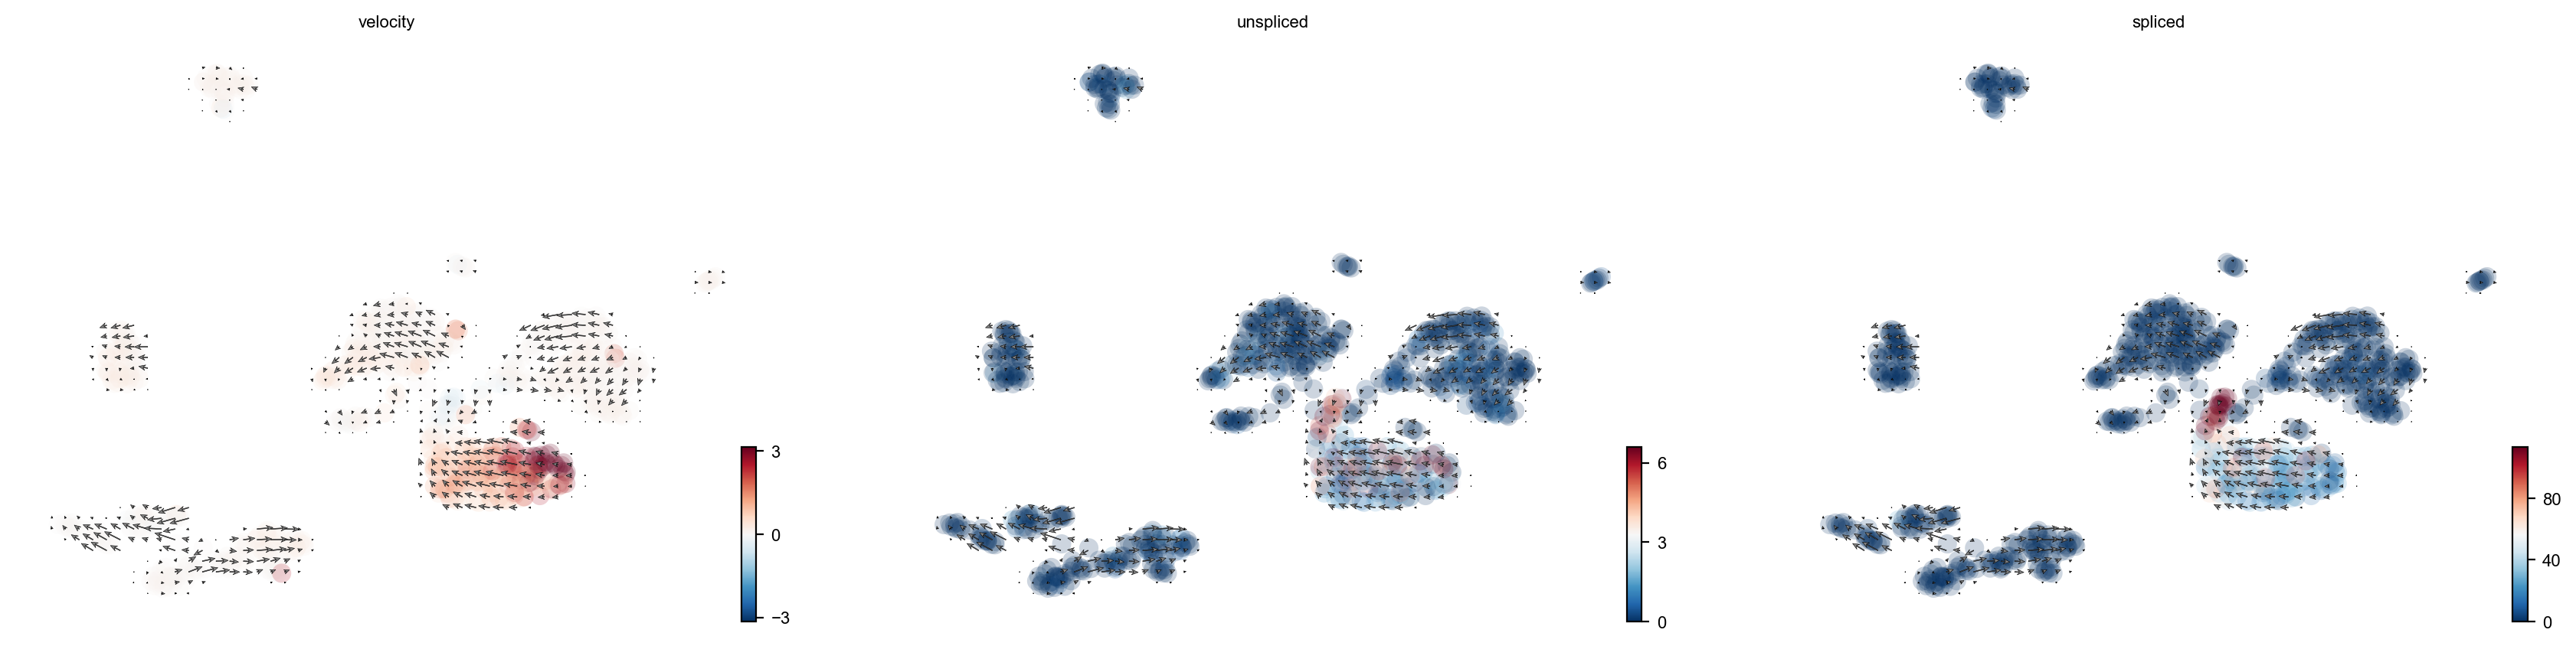

In [113]:
scv.pl.velocity_embedding_grid(adata, color = "Agrp",
                               layer=['velocity','unspliced','spliced'], arrow_size=1.5)

## create table with velocity genes

In [108]:
scv.tl.rank_velocity_genes(adata, match_with='clusters', resolution=4) #???
pd.DataFrame(adata.uns['rank_velocity_genes']['names']).head() #??? what am i looking at

computing velocity clusters
    finished (0:00:00) --> added 
    'velocity_clusters', clusters based on modularity on velocity field (adata.obs)
ranking velocity genes
    finished (0:00:00) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns)


0       1        2              3       4       5        6       7  \
0   Kcnip4  Lingo2    Mecom          Tecrl   Kcnc2      Cp  Col25a1    Fbn2   
1   Prune2   Cntn3    Palmd         Gm9946   Trpc4   Dock6     Sox6     Frk   
2  Cntnap2  Il1rap   Rassf3           Nod1    Dab1  Slc1a3   Adgrv1  Col8a1   
3    Unc5d   Sntg1  Arhgef3          Lima1   Corin   Msrb3  Pcdh11x    Npr3   
4    Dpp10   Cdh12  Slc12a7  4930523C07Rik  Prune2    Ror1    Grik3    Rhoj   

         8        9   ...          15        16        17        18       19  \
0  St3gal6   Kcnip4   ...       Tenm2      Syt1     Kcnq3     Synpr      Ang   
1   Atp10a     Grm7   ...       Robo1    Pcdh15     Corin     Hdac9   Rnase4   
2     Flt1    Vwc2l   ...      Ptchd4     Csmd2      Fbn2   Zfp804a   Lrriq1   
3    Alas1  Fam19a1   ...    Cntnap5b  Fam189a2  Cntnap5c     Nxph1  Pcdh11x   
4    Ptprg   Lrrtm3   ...     Galntl6   Zfp804a     Chrm3  Cntnap5c   Grin3a   

        20       21       22       23      24  
0    Ildr2     Ebf3  Tmem100      Ntm  Arpp21  
1    Pdgfc    Anxa1  Trabd2b    Nhsl1  Rbfox1  
2    Nrcam  Gm49392   Itgbl1  Aldh1a1     Dcc  
3  Col25a1   Sh3bp4  Zcchc24    Cdh20   Plpp4  
4   Dnah11     Fmo2    Cgnl1  Sparcl1  Egfem1  

[5 rows x 25 columns]

In [123]:
adata.write(results_file) 